# TEST: Supervised Autoencoder on MINST

## naive autoencoder VS supervised autoencoder

In [46]:
from keras.layers import Input, Dense
from keras.models import Model

from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard, EarlyStopping
import utilities

from evaluator import Evaluator
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import matplotlib
import umap

#### load data and split: train - test

In [37]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = utilities.from_np_to_one_hot(y_train)
y_test = utilities.from_np_to_one_hot(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# naive autoencoder 32  + UMAP 2

In [33]:
autoencoder,encoder = generate_deep_autoencoder()

path = "test_MINST/esperimento_4" 
tb = TensorBoard(log_dir=path)
er = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)


In [34]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                validation_split=0.2,
                verbose=False,
                callbacks=[tb,er])

autoencoder.evaluate(x_test,x_test)

10000/10000 [==============================] - 1s 64us/step


0.19651037878990174

In [38]:
emb_train = encoder.predict(x_train)
emb_test = encoder.predict(x_test)

In [94]:
eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
acc, pre, rec, f = eva.performance_with_kfold(emb_test,y_test)
print("on 32")
print("K.N.N.  accuracy : ",np.mean(acc))
print("K.N.N.  precision: ",np.mean(pre))
print("K.N.N.  recall   : ",np.mean(rec))
print("K.N.N.  f1       : ",np.mean(f))

on 32
K.N.N.  accuracy :  0.7913
K.N.N.  precision:  0.7938959393600593
K.N.N.  recall   :  0.7913
K.N.N.  f1       :  0.7911577733534545


In [39]:
uma_1 = umap.UMAP(n_components=2)
res_uma_test = uma_1.fit(emb_train,y_train).transform(emb_test)

Dim_2
K.N.N.  accuracy :  0.6441000000000001
K.N.N.  precision:  0.647096061529646
K.N.N.  recall   :  0.6441000000000001
K.N.N.  f1       :  0.6435306394826199


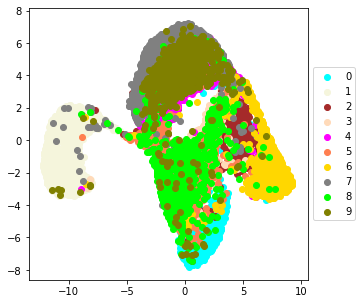

In [88]:
plot_embedding(y_test,res_uma_test)

# SUPERVISED autoencoder 32  + UMAP 2

In [110]:
autoencoder, encoder =  generate_supervised_autoencoder()

In [111]:
path = "test_MINST/esperimento_600" 
tb = TensorBoard(log_dir=path)
autoencoder.fit([x_train], [x_train,y_train],
                epochs=50,
                batch_size=256,
                validation_split=0.2,
                verbose=False,
                callbacks=[tb])


autoencoder.evaluate(x_test,[x_test,y_test])

10000/10000 [==============================] - 0s 48us/step


[0.09405556090474129,
 0.04366835857629776,
 0.5038720138844129,
 0.04366835857629776,
 0.9508]

In [112]:
emb_2_train = encoder.predict(x_train)
emb_2_test = encoder.predict(x_test)

In [126]:
eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
acc, pre, rec, f = eva.performance_with_kfold(emb_2_test,y_test)
print("on 32")
print("K.N.N.  accuracy : ",np.mean(acc))
print("K.N.N.  precision: ",np.mean(pre))
print("K.N.N.  recall   : ",np.mean(rec))
print("K.N.N.  f1       : ",np.mean(f))

on 32
K.N.N.  accuracy :  0.9358000000000001
K.N.N.  precision:  0.9366302888383092
K.N.N.  recall   :  0.9358000000000001
K.N.N.  f1       :  0.9357167810625266


In [127]:
uma_2 = umap.UMAP(n_components=2)
res_uma_2_test = uma_2.fit(emb_2_train,y_train).transform(emb_2_test)

Dim_2
K.N.N.  accuracy :  0.8951
K.N.N.  precision:  0.8962578044513461
K.N.N.  recall   :  0.8951
K.N.N.  f1       :  0.8950382324735644


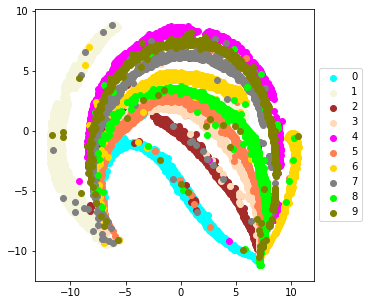

In [128]:
plot_embedding(y_test,res_uma_2_test)

# SUPERVISED autoencoder 32  + UMAP 2 
# MYCALLBACK

In [138]:
from keras import backend as K

w_dec = K.variable(1)
w_cla = K.variable(0.1)

input_img = Input(shape=(784,))
enc = Dense(128, activation='relu')(input_img)
enc = Dense(64, activation='relu')(enc)
enc = Dense(32, activation='relu')(enc)

dec = Dense(64, activation='relu')(enc)
dec = Dense(128, activation='relu')(dec)
dec = Dense(784, activation='sigmoid',name="decoder")(dec)


cla = Dense(10,name="classifier",activation='softmax')(enc)

autoencoder = Model(inputs=input_img,outputs=[dec,cla])
encoder = Model(input_img,enc)

autoencoder.compile(optimizer='adadelta', metrics={'decoder': 'mse', 'classifier': ['acc']},
                    loss = {'decoder': 'mean_squared_error', 'classifier': 'categorical_crossentropy'},
                    loss_weights = {'decoder': w_dec, 'classifier': w_cla})

In [139]:
path = "test_MINST/esperimento_999900" 
tb = TensorBoard(log_dir=path)

epochs = 100
my = MyCallback(w_dec,w_cla,epochs)

[x_train], [x_train,y_train]
h = autoencoder.fit(x_train,
                    {'decoder': x_train, 'classifier': y_train},
                    epochs=epochs,    
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[tb,my])

a = autoencoder.evaluate(x_train,[x_train,y_train])
n = autoencoder.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

60000/60000 [==============================] - 2s 38us/step
loss 0.5512332657337189
decoder_loss 0.08585002087752025
classifier_loss 3.818375109577179
decoder_mean_squared_error 0.08585002087752025
classifier_acc 0.7622166666666667


In [140]:
emb_3_train = encoder.predict(x_train)
emb_3_test = encoder.predict(x_test)

In [141]:
eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
acc, pre, rec, f = eva.performance_with_kfold(emb_3_test,y_test)
print("on 32")
print("K.N.N.  accuracy : ",np.mean(acc))
print("K.N.N.  precision: ",np.mean(pre))
print("K.N.N.  recall   : ",np.mean(rec))
print("K.N.N.  f1       : ",np.mean(f))

on 32
K.N.N.  accuracy :  0.8525
K.N.N.  precision:  0.8548793621369603
K.N.N.  recall   :  0.8525
K.N.N.  f1       :  0.8522483607696272


In [142]:
uma_2 = umap.UMAP(n_components=2)
res_uma_2_test = uma_2.fit(emb_2_train,y_train).transform(emb_2_test)

Dim_2
K.N.N.  accuracy :  0.8881
K.N.N.  precision:  0.8897333362686582
K.N.N.  recall   :  0.8881
K.N.N.  f1       :  0.8881571341933474


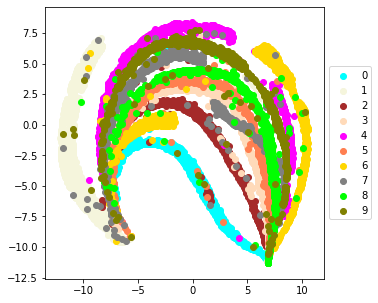

In [143]:
plot_embedding(y_test,res_uma_2_test)

# to use

In [136]:
from keras import callbacks

class MyCallback(callbacks.Callback):
    def __init__(self, w_dec, w_cla, n_epoch):
        
        self.n_epoch = n_epoch
        self.w_dec = w_dec
        self.w_cla = w_cla
        self.w_cals = []
        self.w_decs = []
    # customize your behavior
        
    def on_epoch_end(self, epoch, logs={}):
        
        
        cla = logs['classifier_loss']
        dec = logs['decoder_loss']
        # redi uguale il peso delle 2 loss
        tmp = dec/cla
        
        # dai piu peso al decoder al crescere delle epoche
        new_dec = 5*epoch / (self.n_epoch) 
        
        self.w_decs.append(K.get_value(self.w_dec))
        self.w_cals.append(K.get_value(self.w_cla))
        
        K.set_value(self.w_cla, tmp)
        K.set_value(self.w_dec, new_dec)

In [ ]:
def generate_deep_autoencoder():
    input_img = Input(shape=(784,))
    enc = Dense(128, activation='relu')(input_img)
    enc = Dense(64, activation='relu')(enc)
    enc = Dense(32, activation='relu')(enc)

    dec = Dense(64, activation='relu')(enc)
    dec = Dense(128, activation='relu')(dec)
    dec = Dense(784, activation='sigmoid')(dec)

    autoencoder = Model(input_img,dec)
    encoder = Model(input_img,enc)

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return (autoencoder, encoder)

In [ ]:
def generate_supervised_autoencoder():
    input_img = Input(shape=(784,))
    enc = Dense(128, activation='relu')(input_img)
    enc = Dense(64, activation='relu')(enc)
    enc = Dense(32, activation='relu')(enc)

    dec = Dense(64, activation='relu')(enc)
    dec = Dense(128, activation='relu')(dec)
    dec = Dense(784, activation='sigmoid',name="decoder")(dec)


    cla = Dense(10,name="classifier",activation='softmax')(enc)

    autoencoder = Model(inputs=input_img,outputs=[dec,cla])
    encoder = Model(input_img,enc)

    autoencoder.compile(optimizer='adadelta', metrics={'decoder': 'mse', 'classifier': ['acc']},
                        loss = {'decoder': 'mean_squared_error', 'classifier': 'categorical_crossentropy'},
                        loss_weights = {'decoder': 1, 'classifier': 0.1})
    
    return(autoencoder,encoder)

In [ ]:
def plot_embedding(y_test,res_uma_test):
    
    eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
    acc, pre, rec, f = eva.performance_with_kfold(res_uma_test,y_test)
    print("Dim_2")
    print("K.N.N.  accuracy : ",np.mean(acc))
    print("K.N.N.  precision: ",np.mean(pre))
    print("K.N.N.  recall   : ",np.mean(rec))
    print("K.N.N.  f1       : ",np.mean(f))
    
    tmp_y = utilities.from_one_hot_to_np(y_test)
    group = [ [] for x in range(10)]

    for i in range(len(tmp_y)):
        group[tmp_y[i]].append(res_uma_test[i])

    color_names = ["aqua", "beige", "brown", "peachpuff", "fuchsia","coral","gold","gray","lime","olive"]
    f = plt.figure(figsize=(5,5))
    for i in range(10):
        xx = group[i]
        xx = np.array(xx)
        xx = xx[:,0]
        yy = group[i]
        yy = np.array(yy)
        yy = yy[:,1]

        plt.scatter(xx,yy, c=color_names[i], label=str(i))

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
